[<-- retour à l'index](../index.ipynb)

# Séries de température locales aux échelles annuelle, saisonnière et mensuelle en un point pour la réanalyse ERA5 
Date: Février 2025  
Auteur: Martin Leduc

**Description**  
Affichage des séries de température aux échelles annuelle, saisonnière et mensuelle en un point de grille pour la réanalyse ERA5.

© Copyright Ouranos Inc. and Martin Leduc 2025<br>
This work is licensed under [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Imports
import warnings
import numba

warnings.simplefilter("ignore", category=numba.core.errors.NumbaDeprecationWarning)

import intake
import xarray as xr
import xclim
from clisops.core import subset
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

In [2]:
# Charger les données
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5_NAM.ncml"
#ds = xr.open_dataset(url, chunks={"time": -1, "lat": 50, "lon": 50})
ds = xr.open_dataset(url, chunks={"time": (365*4)+1, "lat": 50, "lon": 50})
ds

<xarray.Dataset> Size: 116GB
Dimensions:  (lat: 320, lon: 680, time: 26571)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.25 10.5 10.75 ... 89.0 89.25 89.5 89.75
  * lon      (lon) float32 3kB -179.9 -179.6 -179.4 ... -10.65 -10.4 -10.15
  * time     (time) datetime64[ns] 213kB 1950-01-01 1950-01-02 ... 2022-09-30
Data variables:
    tas      (time, lat, lon) float32 23GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 23GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 23GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    pr       (time, lat, lon) float32 23GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    prsn     (time, lat, lon) float32 23GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
Attributes: (12/28)
    Conventions:          CF-1.9
    cell_methods:         time: mean (interval: 1 day)
    doi:                  https://doi.org/10.24381/cds.adbb2d47
    domain:               NAM
    frequency:            day
    history:              [2022-12-22 05:12:03.164107] Converted variables an...
    ...                   ...
    institute_id:         ECMWF
    dataset_id:           ERA5
    abstract:             ERA5 provides hourly estimates of a large number of...
    dataset_description:  https://www.ecmwf.int/en/forecasts/datasets/reanaly...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Copernicus Climate Change Service (C3S) (2017): ERA...

In [3]:
# Choisir les années à afficher, la coordonnée du point, et la variable 

# Années pour l'affichage (calculs effectués sur toute la période disponible)
debut,fin=1960, 2020

#ds = ds.tas.sel(time=slice(debut,fin))

# Infos sur les points, format: [lat, lon, site]
ptinfos=[
#         [60, -73.56, 'Nunavik'],
#         [61.36, -57.78,  'Mer du Labrador'],
#         [58.77, -77.79, 'Inukjuak'],     
#         [58.099, -68.418,  'Kuujjuaq'],
#         [59.65991, -85.06750,  'Baie d\'Hudson'],
#         [59.62395, -67.57145,  'Baie d\'Ungava'],  

#         [45.50, -73.56, 'Montreal'],  
          [46.2885, -72.6955, 'Pointe-du-Lac'],
#         [46.820634, -71.232010, 'Québec'],       
        ]

lats=[]
lons=[]
sites=[]
for ligne in ptinfos:
    lats.append(ligne[0])
    lons.append(ligne[1])
    sites.append(ligne[2])

pt = subset.subset_gridpoint(ds.tas, lon=lons, lat=lats)
#pt=pt.assign_coords(site=xr.DataArray(sites,dims="site"))

display(pt)

<xarray.DataArray 'tas' (time: 26571)> Size: 106kB
dask.array<getitem, shape=(26571,), dtype=float32, chunksize=(1461,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 4B 46.25
    lon      float32 4B -72.65
  * time     (time) datetime64[ns] 213kB 1950-01-01 1950-01-02 ... 2022-09-30
Attributes:
    long_name:          2 metre temperature
    original_variable:  t2m
    standard_name:      air_temperature
    units:              K
    cell_methods:       time: point
    _ChunkSizes:        [365  50  50]

KeyError: "'site' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'time': 26571})"

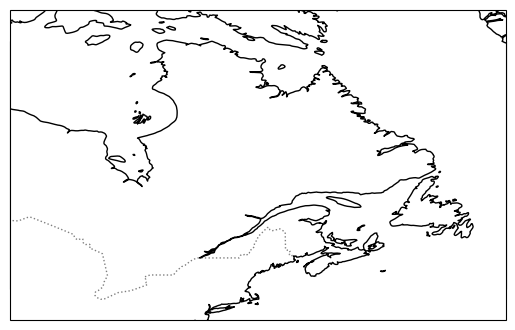

In [4]:
# Créer une figure et des axes avec une projection adaptée (ici, PlateCarree)
fig=plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Créer un axe avec une projection PlateCarree
ax = plt.axes(projection=ccrs.PlateCarree())

# Définir les limites de la carte pour englober la province de Québec
ax.set_extent([-90, -50, 40, 65], crs=ccrs.PlateCarree())  # [lon_min, lon_max, lat_min, lat_max]

# Ajouter des éléments géographiques : côtes, frontières, etc.
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)

for site in sites:
    # Tracer le point à partir des coordonnées du site (lon, lat)
    ptsite=pt.sel(site=site)
    ax.scatter(ptsite.lon, ptsite.lat, marker='o', s=50)

    # Ajouter un label au point
    ax.text(ptsite.lon + 0.5, ptsite.lat, ptsite.site.values, fontsize=12, ha='left', color='black')

# Afficher la carte
plt.show()

## Moyennes annuelles

In [ ]:
# Calcul de la série de moyennes annuelles
ser_ann = pt.groupby('time.year').mean()-273.15

#with ProgressBar():
with Client() as c:
    #display(c)    
    ser_ann.load()
ser_ann

In [ ]:
# Affichage des sếries

plt.plot(ser_ann.year.sel(year=slice(debut,fin)),ser_ann.sel(year=slice(debut,fin)))
#plt.ylim(-5,6)                                              # Fixer les bornes de l'axe vertical
plt.title('Série des moyennes annuelles\n('+str(debut)+' à '+str(fin)+')')

# Ajout du quadrillage secondaire
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()  # Active les graduations mineures

# Titres axes
plt.xlabel("Année")
plt.ylabel("tas ($^\circ$C)")

In [ ]:
## Moyennes saisonnières

In [ ]:
# Calcul de la série de moyennes saisonnières
ser_sais = pt.groupby(["time.season","time.year"]).mean() -273.15

#with ProgressBar():
with Client() as c:
    #display(c)    
    ser_sais.load()
ser_sais

In [ ]:
# Affichage des séries

fig,axes = plt.subplots(2,2,figsize=(8, 8))
axes = axes.ravel()               

for jj,sais in enumerate(['DJF','MAM','JJA','SON']):
    # Afficher la variable
    p=axes[jj].plot(ser_sais.sel(season=sais,year=slice(debut, fin)).year,ser_sais.sel(season=sais,year=slice(debut, fin)))
    
    # Titres panneaux
    axes[jj].title.set_text(sais)
    #axes[jj].set_ylim(-5,5)                      # Fixer les bornes de l'axe vertical

    # Quadrillage
    axes[jj].minorticks_on()  # Active les graduations mineures
    axes[jj].grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')
    
    # Titres axes
    if jj in [0,2]:
        axes[jj].set_ylabel("tas ($^\circ$C)")
    if jj in [2,3]:
        axes[jj].set_xlabel("Année")
        
plt.suptitle('Séries des moyennes saisonnières\n('+str(debut)+' à '+str(fin)+')')
plt.tight_layout()

## Moyennes mensuelles

In [ ]:
# Calcul de la série de moyennes mensuelles
ser_mois = pt.groupby(["time.month","time.year"]).mean() -273.15

#with ProgressBar():
with Client() as c:
    #display(c)    
    ser_mois.load()
ser_mois

In [ ]:
# Affichage des séries

# Liste des mois
mois_num=[12,1,2,3,4,5,6,7,8,9,10,11]
mois_nom=['Décembre','Janvier','Février','Mars','Avril','Mai','Juin','Juillet','Août','Septembre','Octobre','Novembre']

# Graphiques
fig,axes = plt.subplots(4,3,figsize=(8, 8))
axes = axes.ravel()               

for jj,mois in enumerate(mois_num):
    # Afficher la variable
    p=axes[jj].plot(ser_mois.sel(month=mois,year=slice(debut, fin)).year,ser_mois.sel(month=mois,year=slice(debut, fin)))

    # Titres panneaux
    axes[jj].title.set_text(mois_nom[jj])
    #axes[jj].set_ylim(-10,10)                      # Fixer les bornes de l'axe vertical

    # Ajout du quadrillage secondaire
    axes[jj].minorticks_on()  # Active les graduations mineures
    axes[jj].grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')
    
    # Titres axes
    if jj in [0,3,6,9]:
        axes[jj].set_ylabel("tas ($^\circ$C)")
    if jj in [9,10,11]:
        axes[jj].set_xlabel("Année")

    
plt.suptitle('Séries des moyennes mensuelles\n('+str(debut)+' à '+str(fin)+')')
plt.tight_layout()